In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.models import resnet50
from scipy import stats
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from suitability.datasets.dollarstreet import DollarStreetDataset, get_dollarstreet
from suitability.filter.sample_signals import ConfidenceSignal, DecisionBoundarySignal, TrainingDynamicsSignal
import suitability.filter.tests as ftests
from suitability.filter.margin_tuning import tune_margin

import importlib
importlib.reload(ftests)

random.seed(32)
np.random.seed(32)

### Calculate Signals

In [2]:
# Specify dataset path
root_dir = '/mfsnic/u/apouget/data/dollarstreet/dataset_dollarstreet/'

# Load model
model = resnet50(weights=None)
state_dict = torch.load('/mfsnic/u/apouget/experiments/dollarstreet/best_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine data splits
REGIONS = ['eu', 'am', 'as', 'af']

# Construct suitability filter
confidences = {}
decision_boundaries = {}
training_dynamics = {}
correctness = {}

td_checkpoints = [
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_10.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_20.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_30.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_40.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_50.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_60.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_70.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_80.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/last_model.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/best_model.pth'
]

for region in REGIONS:
    model.load_state_dict(state_dict)
    model.to(device)
    data = get_dollarstreet(root_dir, 'test', batch_size=64, shuffle=False, num_workers=4, pre_filter=lambda x: x['region.id'] == region)

    signal = ConfidenceSignal(model, data, device)
    conf, corr = signal.evaluate()
    confidences[region] = conf
    correctness[region] = corr

    signal = DecisionBoundarySignal(model, data, device, max_steps=150, metric='l1', perturbation=0.01)
    db = signal.evaluate()
    decision_boundaries[region] = db

    signal = TrainingDynamicsSignal(model, data, device, td_checkpoints)
    td = signal.evaluate()
    training_dynamics[region] = td
    
    print(f'Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct')

Region eu: 35.28% correct
Region am: 33.64% correct
Region as: 30.54% correct
Region af: 28.93% correct


### Statistical Testing & Margin Tuning

In [59]:
data = get_dollarstreet(root_dir, 'test', batch_size=64, shuffle=True, num_workers=4)
model.load_state_dict(state_dict)
model.to(device)
signal = ConfidenceSignal(model, data, device)
conf, corr = signal.evaluate()
test_fn = ftests.non_inferiority_ttest

conf_margin = tune_margin(corr, conf, confidences['eu'], test_fn, 0.32, delta_x=0.1, initial_m=0.04, delta_m=0.001, accuracy_threshold=0.05, max_iters=100, subsample_size=0)

Iteration 0: Accuracy 0.391 >= 0.32, but p-value 0.054 > 0.05. Increasing m to 0.041.
Iteration 1: Accuracy 0.334 >= 0.32, but p-value 0.859 > 0.05. Increasing m to 0.042.
Iteration 2: Accuracy 0.347 >= 0.32, but p-value 0.410 > 0.05. Increasing m to 0.043.
Iteration 3: Accuracy 0.379 >= 0.32, but p-value 0.063 > 0.05. Increasing m to 0.044.
Iteration 4: Accuracy 0.372 >= 0.32, but p-value 0.330 > 0.05. Increasing m to 0.045.
Iteration 5: Accuracy 0.356 >= 0.32, but p-value 0.168 > 0.05. Increasing m to 0.046.
Iteration 6: Accuracy 0.348 >= 0.32, but p-value 0.444 > 0.05. Increasing m to 0.047.
Iteration 7: Accuracy 0.343 >= 0.32, but p-value 0.400 > 0.05. Increasing m to 0.048.
Iteration 8: Accuracy 0.385 >= 0.32, but p-value 0.140 > 0.05. Increasing m to 0.049.
Iteration 9: Accuracy 0.329 >= 0.32, but p-value 0.508 > 0.05. Increasing m to 0.050.
Iteration 10: Accuracy 0.341 >= 0.32, but p-value 0.398 > 0.05. Increasing m to 0.051.
Iteration 11: Accuracy 0.410 >= 0.32, but p-value 0.1

In [22]:
db_margin = 0.1
td_margin = 0.02

for region in ['am', 'as', 'af']:
    print(f'EU vs {region} confidences:', test_fn(confidences['eu'], confidences[region], margin=conf_margin))
    print(f'EU vs {region} decision boundaries:', test_fn(decision_boundaries['eu'], decision_boundaries[region], increase_good=False, margin=db_margin))
    print(f'EU vs {region} training dynamics:', test_fn(training_dynamics['eu'], training_dynamics[region], increase_good=False, margin=td_margin))

EU vs am confidences: {'t_statistic': -2.6159951873515106, 'p_value': 0.004494782198108248, 'reject_null': True}
EU vs am decision boundaries: {'t_statistic': 1.8963370602620466, 'p_value': 0.029054923877017597, 'reject_null': True}
EU vs am training dynamics: {'t_statistic': 1.9898468553088264, 'p_value': 0.023398034897247465, 'reject_null': True}
EU vs as confidences: {'t_statistic': -1.5619433086512562, 'p_value': 0.059284932175089906, 'reject_null': False}
EU vs as decision boundaries: {'t_statistic': 0.4403945011064153, 'p_value': 0.3298618125384283, 'reject_null': False}
EU vs as training dynamics: {'t_statistic': 1.2745864077290594, 'p_value': 0.10135010917104498, 'reject_null': False}
EU vs af confidences: {'t_statistic': -0.2850217622466289, 'p_value': 0.38783435457419, 'reject_null': False}
EU vs af decision boundaries: {'t_statistic': 0.25919702930156585, 'p_value': 0.3977595473859345, 'reject_null': False}
EU vs af training dynamics: {'t_statistic': -0.3859213231878335, 'p_

In [23]:
# Function to perform t-tests and calculate accuracy for different sample sizes across multiple trials
def run_tests_for_samples(signals, correctness, sample_sizes, test_fn, n_trials=100, increase_good=True, margin=0):
    results = []
    
    for sample_size in sample_sizes:
        for trial in range(n_trials):  # Multiple trials for each sample size
            row = {'sample_size': sample_size, 'trial': trial}
            for region in ['am', 'as', 'af']:
                # Sample from the confidence scores and correctness of the region
                sampled_indices = random.sample(range(len(signals[region])), min(sample_size, len(signals[region])))
                sampled_signals = [signals[region][i] for i in sampled_indices]
                sampled_correctness = [correctness[region][i] for i in sampled_indices]
                
                # Perform t-test between EU and the sampled region
                res = test_fn(np.array(signals['eu']), np.array(sampled_signals), increase_good=increase_good, margin=margin)
                row[f'p-value eu vs {region}'] = res["p_value"]
                row[f't-statistic eu vs {region}'] = res["t_statistic"]
                
                # Calculate accuracy of the sampled region
                sampled_accuracy = np.mean(sampled_correctness) * 100  # Accuracy in percentage
                row[f'accuracy {region}'] = sampled_accuracy
            
            results.append(row)

    return pd.DataFrame(results)

# Sample sizes to test
sample_sizes = [5, 10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]

# Run tests across multiple trials for confidence, decision boundaries, and training dynamics
df_conf = run_tests_for_samples(confidences, correctness, sample_sizes, test_fn, n_trials=100, margin=conf_margin)
df_db = run_tests_for_samples(decision_boundaries, correctness, sample_sizes, test_fn, n_trials=100, increase_good=False, margin=db_margin)
df_td = run_tests_for_samples(training_dynamics, correctness, sample_sizes, test_fn, n_trials=100, increase_good=False, margin=td_margin)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


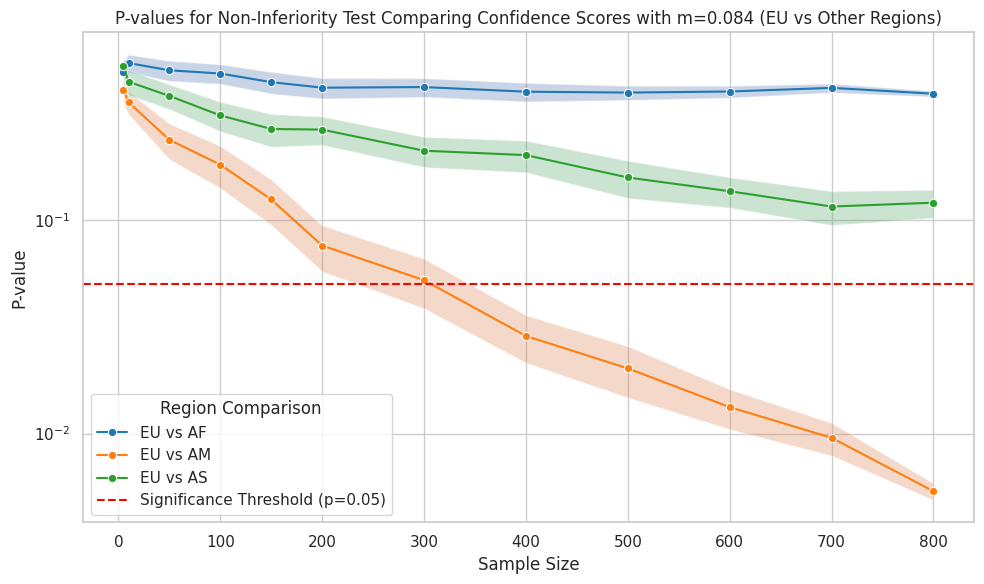

In [29]:
# Select one of the DataFrames to plot
df = df_conf
name = f"Confidence Scores with m={conf_margin:.3f}"

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars=['sample_size', 'trial'], value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af'],
                    var_name='Comparison', value_name='p-value')

# Rename columns for better readability in the plot
df_melted['Comparison'] = df_melted['Comparison'].replace({
    'p-value eu vs am': 'EU vs AM',
    'p-value eu vs as': 'EU vs AS',
    'p-value eu vs af': 'EU vs AF'
})

# Group by sample size and comparison, then calculate mean and 95% CI
df_summary = df_melted.groupby(['sample_size', 'Comparison']).agg(
    p_value_mean=('p-value', 'mean'),
    p_value_std=('p-value', 'std'),
    n=('p-value', 'size')
).reset_index()

# Calculate the 95% confidence intervals
df_summary['ci_upper'] = df_summary['p_value_mean'] + 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))
df_summary['ci_lower'] = df_summary['p_value_mean'] - 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))

# Create the plot with means and confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_summary, x='sample_size', y='p_value_mean', hue='Comparison', marker='o', palette='tab10')

# Plot the confidence interval as a shaded region
for comparison in df_summary['Comparison'].unique():
    subset = df_summary[df_summary['Comparison'] == comparison]
    plt.fill_between(subset['sample_size'], subset['ci_lower'], subset['ci_upper'], alpha=0.3)

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title(f'P-values for Non-Inferiority Test Comparing {name} (EU vs Other Regions)')
plt.xlabel('Sample Size')
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Use logarithmic scale for p-values
plt.legend(title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()

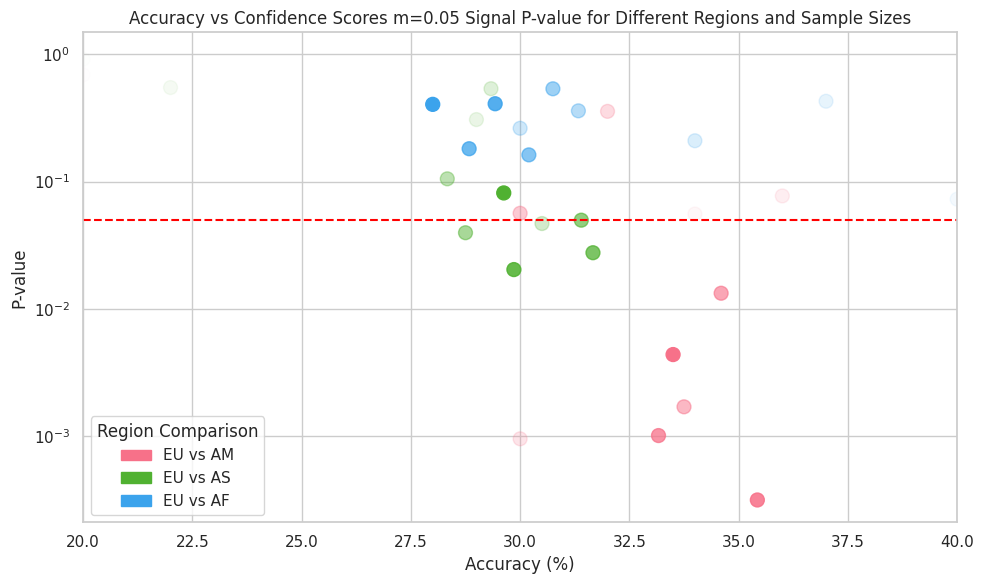

In [30]:
# Prepare the data for plotting
df_melted = df.melt(id_vars='sample_size', 
                    value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af',
                                'accuracy am', 'accuracy as', 'accuracy af'], 
                    var_name='Metric', value_name='Value')

# Extract region and metric type (p-value or accuracy)
df_melted['Region'] = df_melted['Metric'].apply(lambda x: x.split()[-1])  # Get the region (am, as, af)
df_melted['Metric'] = df_melted['Metric'].apply(lambda x: ' '.join(x.split()[:-1]))  # Get metric (p-value or accuracy)

# Pivot the DataFrame to get separate columns for accuracy and p-values
df_plot = df_melted.pivot_table(index=['sample_size', 'Region'], columns='Metric', values='Value').reset_index()

# Normalize the sample size to create a brightness scale for colors
norm = plt.Normalize(df_plot['sample_size'].min(), df_plot['sample_size'].max())

# Set up the color palette
palette = sns.color_palette("husl", 3)  # A color palette with 3 distinct colors for am, as, af
region_colors = {'am': palette[0], 'as': palette[1], 'af': palette[2]}

# Plotting
plt.figure(figsize=(10, 6))
for region in ['am', 'as', 'af']:
    subset = df_plot[df_plot['Region'] == region]
    plt.scatter(subset['accuracy'], subset[f'p-value eu vs'], 
                c=[region_colors[region]] * len(subset), 
                s=100,  # Marker size
                alpha=norm(subset['sample_size']),  # Brighter color for larger sample sizes
                label=f'EU vs {region.upper()}')

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

legend_handles = [
    mpatches.Patch(color=region_colors['am'], label='EU vs AM'),
    mpatches.Patch(color=region_colors['as'], label='EU vs AS'),
    mpatches.Patch(color=region_colors['af'], label='EU vs AF')
]

# Customize the plot
plt.title(f'Accuracy vs {name} Signal P-value for Different Regions and Sample Sizes')
plt.xlabel('Accuracy (%)')
plt.ylabel('P-value')
plt.xlim(20,40)
plt.yscale('log')  # Optional: Log scale for p-values for better visibility
plt.legend(handles=legend_handles, title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()


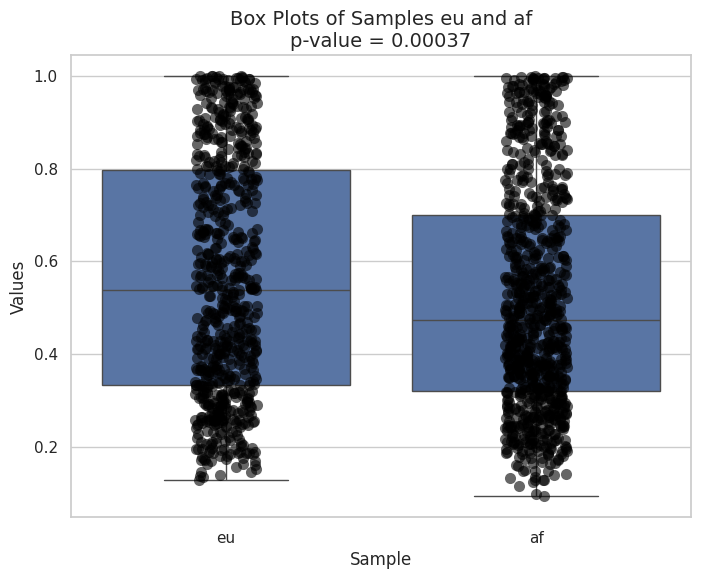

In [ ]:
def plot_samples_with_pvalue(x1, x2, test_fn, name1, name2):
    # Perform the statistical test
    test_statistic, p_value = test_fn(x1, x2)
    
    # Create a DataFrame for plotting
    data = {
        'Sample': [name1] * len(x1) + [name2] * len(x2),
        'Values': np.concatenate([x1, x2])
    }
    
    # Create the box plots
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Sample', y='Values', data=data)
    
    # Overlay individual data points using stripplot
    sns.stripplot(x='Sample', y='Values', data=data, color='black', jitter=True, size=8, alpha=0.6)
    
    # Add the p-value to the title
    plt.title(f'Box Plots of Samples {name1} and {name2}\np-value = {p_value:.5f}', fontsize=14)
    
    # Display the plot
    plt.show()


plot_samples_with_pvalue(confidences['eu'], confidences['af'], test_fn, 'eu', 'af')
